## Import all the needed packages

In [1]:
%matplotlib inline

# DataFrame
import pandas as pd

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

# datetime
from datetime import datetime

# isnan()
import math

# plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Make plots look nice

In [2]:
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')
figsize = 12
s = {
 u'axes.edgecolor': u'#333333',
 u'axes.facecolor': u'#eeeeee',
 u'axes.grid': True,
 u'axes.labelsize': u'large',
 u'axes.labelcolor': u'#333333',
 u'axes.titlesize': u'x-large',
 u'examples.directory': u'',
 u'legend.fancybox': True,
 u'lines.linewidth': 2.0,
 u'patch.edgecolor': u'#eeeeee',
 u'patch.linewidth': 0.5,
 u'figure.figsize':(10,7)}
mpl.rcParams.update(s)

## Create the local raw_data_pool

In [3]:
raw_data_pool = {}

def make_sure(src_site, dest_site):
    if src_site not in raw_data_pool:
        raw_data_pool[src_site] = {}
    if dest_site not in raw_data_pool[src_site]:
        raw_data_pool[src_site][dest_site] = pd.DataFrame()

def put_data(src_site, dest_site, timestamp_epoch, column_type, value):
    make_sure(src_site, dest_site)
    raw_data_pool[src_site][dest_site].set_value(timestamp_epoch, column_type, value)

## Create the elasticsearch connection

In [4]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=6000)

## Generate the common part of the queries

In [5]:
# Note that this is just my weird way to do it. Please refer to Ilija's codes to see the right way to do it. 

src_site = "source_site"
dest_site = "destination_site"

timestamp = { 'gte': '2016-01-01', 'lt': '2016-06-01' }

my_query = {}
my_query['query'] = {}
my_query['query']['filtered'] = {}
my_query['query']['filtered']['query'] = { "match_all": {} }
my_query['query']['filtered']['filter'] = {}
my_query['query']['filtered']['filter']['bool'] = {}
my_query['query']['filtered']['filter']['bool']['must'] = []
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'srcSite': src_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'destSite': dest_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'range': { 'timestamp': timestamp } })
my_query['fielddata_fields'] = [ 'timestamp' ]

print(my_query)

my_index = "network_weather_2-*"

print(my_index)

{'query': {'filtered': {'query': {'match_all': {}}, 'filter': {'bool': {'must': [{'term': {'srcSite': 'source_site'}}, {'term': {'destSite': 'destination_site'}}, {'range': {'timestamp': {'lt': '2016-06-01', 'gte': '2016-01-01'}}}]}}}}, 'fielddata_fields': ['timestamp']}
network_weather_2-*


## Define the function to collect and clean the raw data for a given src/dest pair

In [6]:
def collect_and_clean(src_site, dest_site):
    
    # Set the source/destination pair
    my_query['query']['filtered']['filter']['bool']['must'][0]['term']['srcSite'] = src_site
    my_query['query']['filtered']['filter']['bool']['must'][1]['term']['destSite'] = dest_site
    print(my_query)
    print()
    
    # Collect latency raw data
    my_type = 'latency'
    scroll = list(helpers.scan(client=es, query=my_query, index=my_index, doc_type=my_type, request_timeout=6000))
    count = 0
    for result in scroll:
        count += 1
        timestamp_epoch = result['fields']['timestamp'][0]
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', result['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_median', result['_source']['delay_median'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_mean', result['_source']['delay_mean'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_sd', result['_source']['delay_sd'])
    print('Number of raw records of {} is {}'.format(my_type, count))
    
    # Collect packet_loss_rate raw data
    my_type = 'packet_loss_rate'
    scroll = list(helpers.scan(client=es, query=my_query, index=my_index, doc_type=my_type, request_timeout=6000))
    count = 0
    for result in scroll:
        count += 1
        timestamp_epoch = result['fields']['timestamp'][0]
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', result['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'packet_loss', result['_source']['packet_loss'])
    print('Number of raw records of {} is {}'.format(my_type, count))
    
    # Collect throughput raw data
    my_type = 'throughput'
    scroll = list(helpers.scan(client=es, query=my_query, index=my_index, doc_type=my_type, request_timeout=6000))
    count = 0
    for result in scroll:
        count += 1
        timestamp_epoch = result['fields']['timestamp'][0]
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', result['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'throughput', result['_source']['throughput'])
    print('Number of raw records of {} is {}'.format(my_type, count))
    
    # View statistics of raw_data_pool (already de-duplicated)
    print()
    print('De-duplication result:')
    print(raw_data_pool[src_site][dest_site].count(axis='index'))
    
    # Sort in-place
    raw_data_pool[src_site][dest_site].sort_index(inplace=True)
    
    # Store this DataFrame to disk file
    raw_data_pool[src_site][dest_site].to_pickle('My_data/My_data_from_{}_to_{}_sorted.pkl'.format(src_site, dest_site))
    
    # How to get this DataFrame
    # raw_data_pool[src_site][dest_site]


print('Successfully defined the collect_and_clean(src_site, dest_site) function')


Successfully defined the collect_and_clean(src_site, dest_site) function


In [7]:
sites = ['Australia-ATLAS', 'SFU-LCG2', 'MWT2', 'CERN-PROD', 'BEIJING-LCG2']

count = 0
for src_site in sites:
    for dest_site in sites:
        if src_site != dest_site:
            count += 1
            print('=============================================================================')
            print('{}. Now the pair is {} / {}'.format(count, src_site, dest_site))
            print()
            collect_and_clean(src_site, dest_site)
            print('=============================================================================')



1. Now the pair is Australia-ATLAS / SFU-LCG2

{'query': {'filtered': {'query': {'match_all': {}}, 'filter': {'bool': {'must': [{'term': {'srcSite': 'Australia-ATLAS'}}, {'term': {'destSite': 'SFU-LCG2'}}, {'range': {'timestamp': {'lt': '2016-06-01', 'gte': '2016-01-01'}}}]}}}}, 'fielddata_fields': ['timestamp']}

Number of raw records of latency is 56714
Number of raw records of packet_loss_rate is 57986
Number of raw records of throughput is 21

De-duplication result:
iso_8601        3219
delay_median    3105
delay_mean      3105
delay_sd        3105
packet_loss     3177
throughput        21
dtype: int64
2. Now the pair is Australia-ATLAS / MWT2

{'query': {'filtered': {'query': {'match_all': {}}, 'filter': {'bool': {'must': [{'term': {'srcSite': 'Australia-ATLAS'}}, {'term': {'destSite': 'MWT2'}}, {'range': {'timestamp': {'lt': '2016-06-01', 'gte': '2016-01-01'}}}]}}}}, 'fielddata_fields': ['timestamp']}

Number of raw records of latency is 74404
Number of raw records of packet_loss

In [8]:
raw_data_pool['Australia-ATLAS']['BEIJING-LCG2']

,iso_8601,delay_median,delay_mean,delay_sd,packet_loss,throughput
1451606400000,2016-01-01T00:00:00,78.70,78.704056,0.053543,0.00000,NaN
1451607000000,2016-01-01T00:10:00,78.50,78.506000,0.053516,0.00000,NaN
1451608800000,2016-01-01T00:40:00,78.30,78.375208,0.142850,0.00000,NaN
1451609400000,2016-01-01T00:50:00,76.70,76.699722,0.071840,0.00000,NaN
1451610134000,2016-01-01T01:02:14,NaN,NaN,NaN,NaN,279726000.0
1451611500000,2016-01-01T01:25:00,78.40,78.532000,1.244686,0.00000,NaN
1451611800000,2016-01-01T01:30:00,78.20,78.162000,0.070399,0.00000,NaN
1451613900000,2016-01-01T02:05:00,79.60,79.614867,0.140377,0.00000,NaN
1451614200000,2016-01-01T02:10:00,79.80,79.816500,0.045947,0.00000,NaN
1451616600000,2016-01-01T02:50:00,81.70,81.691778,0.053220,0.00000,NaN


## Start analyzing the clean data

In [9]:
def nearest_before_resample(src_site, dest_site):
    # First, read in clean data
    data = pd.read_pickle('My_data/My_data_from_{}_to_{}_sorted.pkl'.format(src_site, dest_site))
    # Then, create the result variable
    resample = pd.DataFrame()
    # Then, create the needed counters
    packet_loss_equals_zero = 0
    packet_loss_not_equals_zero = 0
    # Do the resample work!
    row = data.shape[0]
    for r in range(row):
        line = data.iloc[r]
        if not math.isnan(line['throughput']):
            # This time has the throughput data, so add throughput data into resample
            resample.set_value(data.index[r], 'iso_8601', line['iso_8601'])
            resample.set_value(data.index[r], 'throughput', line['throughput'])
            # Then, find and add a suitable delay_median data into resample
            rr = r
            while rr >= 0:
                if not math.isnan(data.iloc[rr]['delay_median']):
                    resample.set_value(data.index[r], 'delay_median', data.iloc[rr]['delay_median'])
                    # dmdtbm = delay_median_deltaT_before(minutes)
                    resample.set_value(data.index[r], 'dmdtbm', (data.index[r] - data.index[rr]) / 1000 / 60)   # minutes
                    break
                else:
                    rr -= 1
            # Finally, find and add a suitable packet_loss data into resample
            rr = r
            while rr >= 0:
                if not math.isnan(data.iloc[rr]['packet_loss']):
                    resample.set_value(data.index[r], 'packet_loss', data.iloc[rr]['packet_loss'])
                    if data.iloc[rr]['packet_loss'] == 0.0:
                        packet_loss_equals_zero += 1
                    else:
                        packet_loss_not_equals_zero += 1
                    # pldtbm = packet_loss_deltaT_before(minutes)
                    resample.set_value(data.index[r], 'pldtbm', (data.index[r] - data.index[rr]) / 1000 / 60)   # minutes
                    break
                else:
                    rr -= 1
    # Store the result variable to disk file
    resample.to_pickle('My_data/Nearest_before_resample_from_{}_to_{}.pkl'.format(src_site, dest_site))
    # Finally, print the needed summary information
    print()
    print('==========================================================================')
    print('Source Site: {}'.format(src_site))
    print('Destination Site: {}'.format(dest_site))
    print('packet_loss == 0 records: {}'.format(packet_loss_equals_zero))
    print('packet_loss != 0 records: {}'.format(packet_loss_not_equals_zero))
    print('==========================================================================')

In [10]:
sites = ['Australia-ATLAS', 'SFU-LCG2', 'MWT2', 'CERN-PROD', 'BEIJING-LCG2']

count = 0
for src_site in sites:
    for dest_site in sites:
        if src_site != dest_site:
            count += 1
            print('{}. ============================================================================='.format(count))
            nearest_before_resample(src_site, dest_site)

1. =============================================================================

Source Site: Australia-ATLAS
Destination Site: SFU-LCG2
packet_loss == 0 records: 21
packet_loss != 0 records: 0
2. =============================================================================

Source Site: Australia-ATLAS
Destination Site: MWT2
packet_loss == 0 records: 104
packet_loss != 0 records: 2
3. =============================================================================

Source Site: Australia-ATLAS
Destination Site: CERN-PROD
packet_loss == 0 records: 16
packet_loss != 0 records: 0
4. =============================================================================

Source Site: Australia-ATLAS
Destination Site: BEIJING-LCG2
packet_loss == 0 records: 723
packet_loss != 0 records: 29
5. =============================================================================

Source Site: SFU-LCG2
Destination Site: Australia-ATLAS
packet_loss == 0 records: 45
packet_loss != 0 records: 1
6. ==================

In [ ]:
def draw_throughput_vs_delay_median(src_site, dest_site):
    # First, read in data
    data = pd.read_pickle('My_data/Nearest_before_resample_from_{}_to_{}.pkl'.format(src_site, dest_site))
    # Second, calculate the needed variables
    dm = data.delay_median
    tp = data.throughput / 1024. / 1024. / 1024.
    pl = data.packet_loss
    # Third, draw them
    plt.figure(figsize=[4, 2])
    plt.scatter(dm, tp, s=80, c='#0000FF', alpha=.8)
    plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (Gbps)')
    plt.title('{} / {}'.format(src_site, dest_site))
    plt.show()

1. =============================================================================


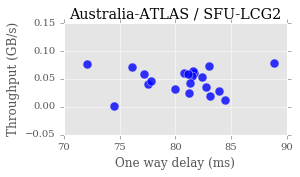

2. =============================================================================


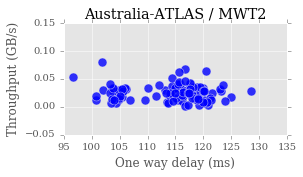

3. =============================================================================


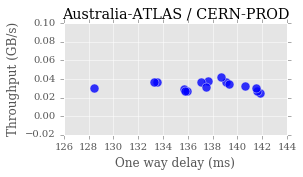

4. =============================================================================


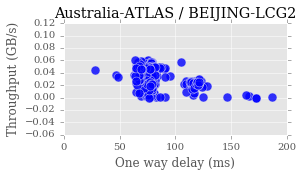

5. =============================================================================


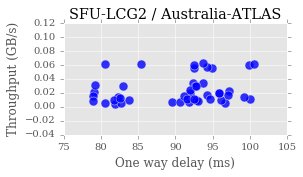

6. =============================================================================


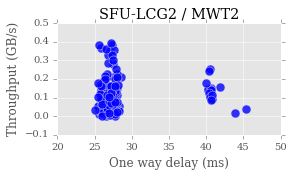

7. =============================================================================


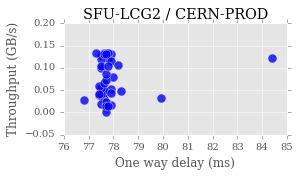

8. =============================================================================


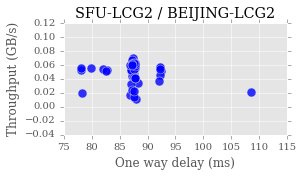

9. =============================================================================


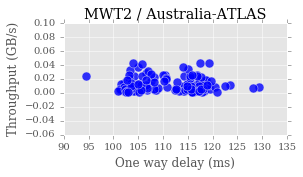

10. =============================================================================


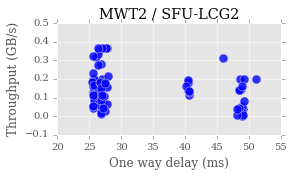

11. =============================================================================


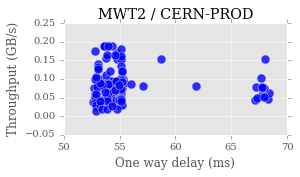

12. =============================================================================


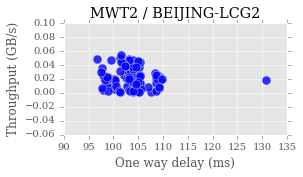

13. =============================================================================


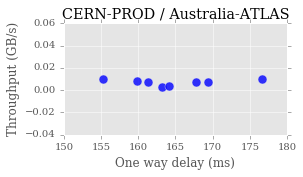

14. =============================================================================


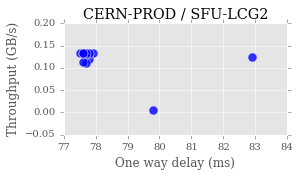

15. =============================================================================


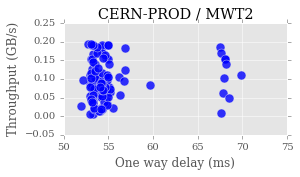

16. =============================================================================


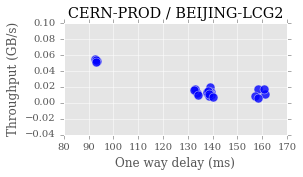

17. =============================================================================


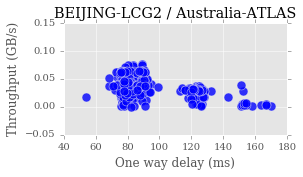

18. =============================================================================


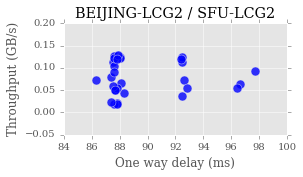

19. =============================================================================


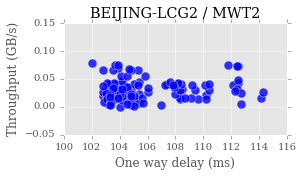

20. =============================================================================


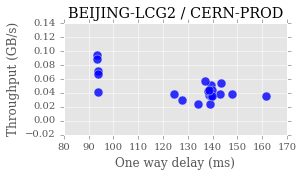

In [14]:
sites = ['Australia-ATLAS', 'SFU-LCG2', 'MWT2', 'CERN-PROD', 'BEIJING-LCG2']

count = 0
for src_site in sites:
    for dest_site in sites:
        if src_site != dest_site:
            count += 1
            print('{}. ============================================================================='.format(count))
            draw_throughput_vs_delay_median(src_site, dest_site)

In [13]:
plt.style.use('ggplot')   # Change plot style to ggplot

1. =============================================================================


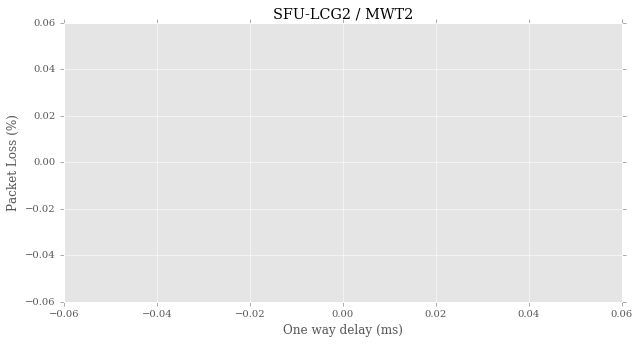

2. =============================================================================


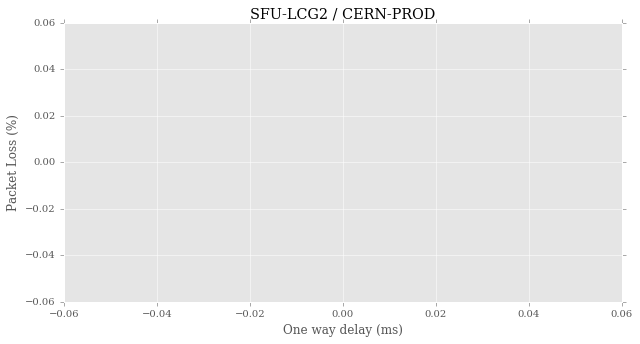

3. =============================================================================


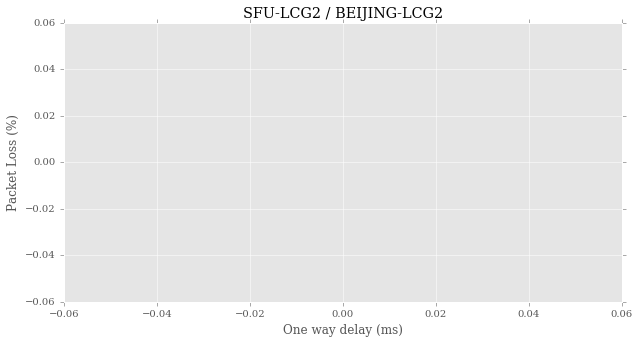

4. =============================================================================


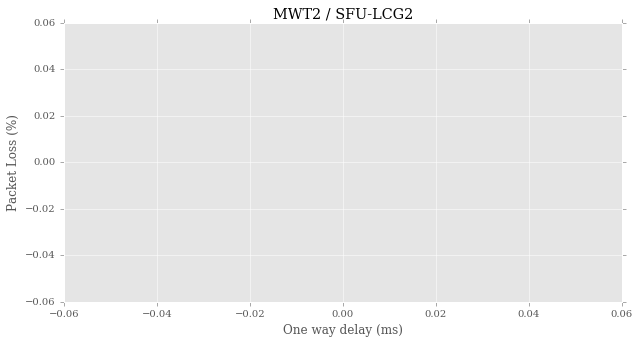

5. =============================================================================


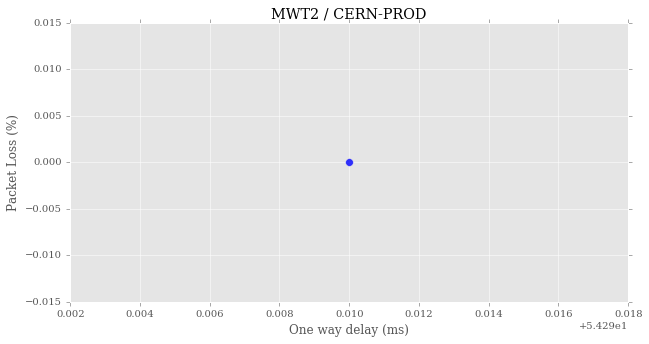

6. =============================================================================


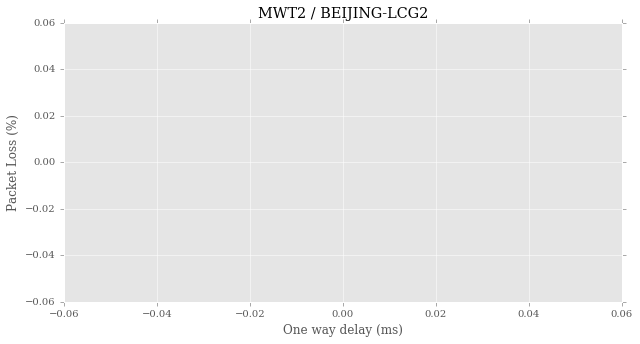

7. =============================================================================


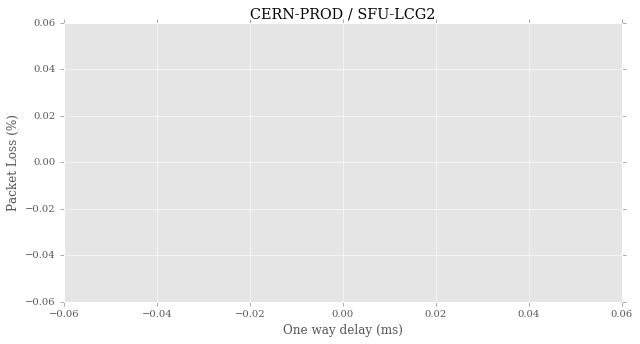

8. =============================================================================


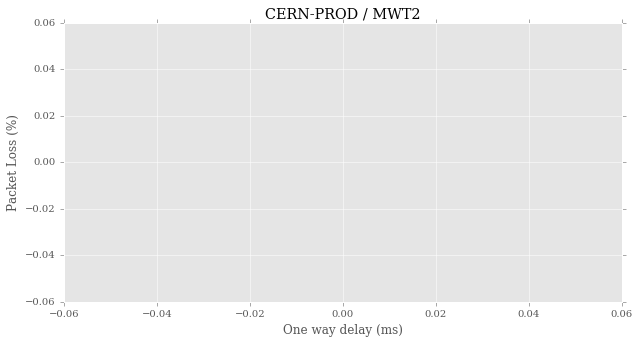

9. =============================================================================


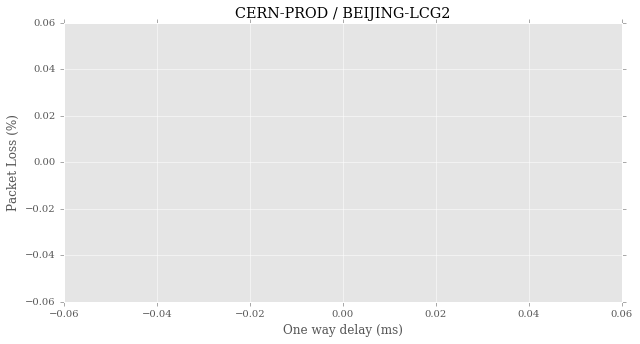

10. =============================================================================


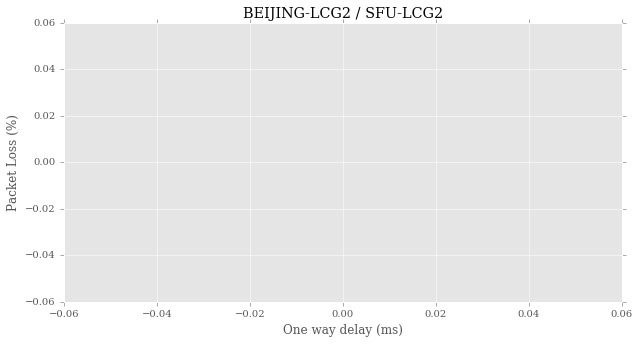

11. =============================================================================


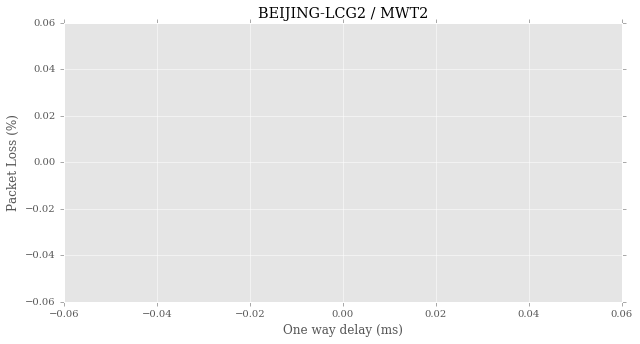

12. =============================================================================


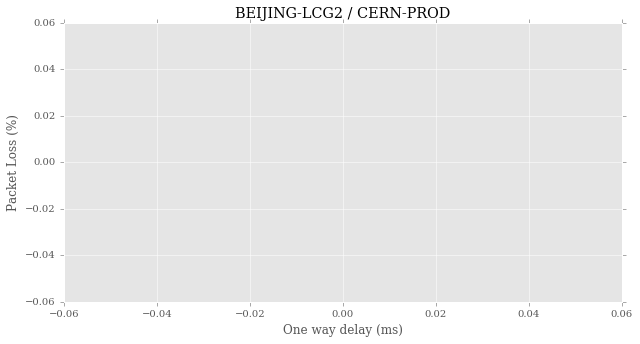

In [26]:
sites = ['SFU-LCG2', 'MWT2', 'CERN-PROD', 'BEIJING-LCG2']

count = 0
for src_site in sites:
    for dest_site in sites:
        if src_site != dest_site:
            count += 1
            print('{}. ============================================================================='.format(count))
            data = pd.read_pickle('My_data/My_data_from_{}_to_{}_sorted.pkl'.format(src_site, dest_site))
#             print(data)
            # Second, calculate the needed variables
            dm = data.delay_median
            tp = data.throughput / 1024.0 / 1024.0 / 1024. 
            pl = data.packet_loss
            # Third, draw them
            plt.figure(figsize=[10, 5])
            plt.scatter(dm, pl, c='#0000FF', s=tp*100,  alpha=.8, cmap='Blues')
            plt.xlabel('One way delay (ms)'), plt.ylabel('Packet Loss (%)')
            plt.title('{} / {}'.format(src_site, dest_site))
        #     plt.colorbar()
            plt.show()

In [ ]:
def norm_delay_and_packet_loss(src_site, dest_site):
    data = pd.read_pickle('My_data/My_data_from_{}_to_{}_sorted.pkl'.format(src_site, dest_site))

    dm = data.delay_median
    tp = data.throughput / 1024 / 1024 / 1024 / 8
    pl = data.packet_loss

    plt.figure(figsize=[16, 9])
    plt.plot(data.index, (dm - np.mean(dm)) / np.std(dm), label='delay (ms)')
    plt.plot(data.index, (pl - np.mean(pl)) / np.std(pl), label='packet loss (%)')
    plt.scatter(data.index, (tp - np.mean(tp)) / np.std(tp) * 10 * -1, label='throughput (GB/s)', c='#7fb800', s=30)
    plt.legend()
    plt.xlabel('Time (unix time)')
    plt.title('{} / {}'.format(src_site, dest_site))
    plt.show()
    
    d = dm[dm.notnull()]
    plt.figure(figsize=[10, 9])
    plt.hist((d-np.mean(d))/np.std(d), 50, facecolor='green', alpha=0.75)
    plt.show()

In [ ]:
sites = ['SFU-LCG2', 'MWT2', 'CERN-PROD', 'BEIJING-LCG2']

count = 0
for src_site in sites:
    for dest_site in sites:
        if src_site != dest_site:
            count += 1
            print('{}. ============================================================================='.format(count))
            norm_delay_and_packet_loss(src_site, dest_site)